In [119]:
# !unzip './content/Phase2.zip' './content/'

## Imports

In [120]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from keras.preprocessing.image import ImageDataGenerator

In [121]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-2
NUM_CLASSES = 3
CLASSES = ['Gaussian', 'Periodic', 'Salt']
N_CHANNELS = 1

In [122]:
base_dir = './content/DataSet2'

In [123]:
def plt_figure(images: list, titles: list, cmap='gray', rows=1, columns=1, w=5, h=5):
    fig = plt.figure(figsize=(w, h))
    count = 1
    for image, title in zip(images, titles):
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.title(title)

In [124]:
# def convert_to_ms(image):
#     image = np.fft.fftshift(np.fft.fft2(image))
#     image = 20*np.log(np.abs(image))
#     return image

def convert_to_ms(image):
    if(N_CHANNELS==3):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.fft.fftshift(np.fft.fft2(image))
    image = 20*(np.log(np.abs(image)))
    image = (image / np.max(image))*255
    image = np.uint8(np.round(image))
    if(N_CHANNELS==3):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image = image/255
    return image

In [125]:
import keras.utils as image

def load_test_image(path):
    img = image.load_img(path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

In [126]:
data = pd.read_excel('./content/Labels.xlsx')
data.head()

,Denoise Image,Noise Type,Noisy Image
0,Without-Noise/cast_def_0_0.jpeg,Gaussian,With-Noise/cast_def_0_0.jpeg
1,Without-Noise/cast_def_0_2.jpeg,Gaussian,With-Noise/cast_def_0_2.jpeg
2,Without-Noise/cast_def_0_22.jpeg,Gaussian,With-Noise/cast_def_0_22.jpeg
3,Without-Noise/cast_def_0_25.jpeg,Gaussian,With-Noise/cast_def_0_25.jpeg
4,Without-Noise/cast_def_0_33.jpeg,Gaussian,With-Noise/cast_def_0_33.jpeg


In [127]:
data['Noise Type']

0       Gaussian
1       Gaussian
2       Gaussian
3       Gaussian
4       Gaussian
          ...   
1245        Salt
1246        Salt
1247        Salt
1248        Salt
1249        Salt
Name: Noise Type, Length: 1250, dtype: object

In [128]:
data = pd.DataFrame({
    "images" : [os.path.join(base_dir, dir) for dir in data['Noisy Image']],
    "labels" : data['Noise Type']
    })
data

,images,labels
0,./content/DataSet2\With-Noise/cast_def_0_0.jpeg,Gaussian
1,./content/DataSet2\With-Noise/cast_def_0_2.jpeg,Gaussian
2,./content/DataSet2\With-Noise/cast_def_0_22.jpeg,Gaussian
3,./content/DataSet2\With-Noise/cast_def_0_25.jpeg,Gaussian
4,./content/DataSet2\With-Noise/cast_def_0_33.jpeg,Gaussian
...,...,...
1245,./content/DataSet2\With-Noise/cast_ok_0_9397.jpeg,Salt
1246,./content/DataSet2\With-Noise/cast_ok_0_9411.jpeg,Salt
1247,./content/DataSet2\With-Noise/cast_ok_0_9464.jpeg,Salt
1248,./content/DataSet2\With-Noise/cast_ok_0_9494.jpeg,Salt


In [129]:
from sklearn.utils import shuffle 
data = shuffle(data, random_state=50)

In [130]:
train_datagen=ImageDataGenerator(
    # preprocessing_function=convert_to_ms,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # rotation_range=5,
    # fill_mode='nearest'
    )
test_datagen=ImageDataGenerator(
    # preprocessing_function=convert_to_ms,
    rescale=1./255
    )

In [131]:
train_gen = train_datagen.flow_from_dataframe(
    data,
    x_col='images',
    y_col='labels',
    classes=CLASSES,
    class_mode='categorical',
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE,
    subset='training',
    seed=0
)

val_gen = train_datagen.flow_from_dataframe(
    data,
    x_col='images',
    y_col='labels',
    classes=CLASSES,
    class_mode='categorical',
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE,
    subset='validation',
    seed=1
)

Found 1000 validated image filenames belonging to 3 classes.
Found 250 validated image filenames belonging to 3 classes.


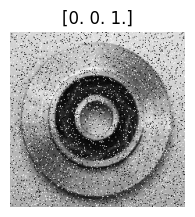

In [132]:
plt_figure([train_gen[10][0][29]],[f'{train_gen[10][1][29]}'],rows=2)

# Training Models

In [133]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks for early stopping, model checkpointing, and learning rate reduction
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

## VGG16

In [134]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model



# Load pre-trained VGG16 model without the top layers
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze pre-trained layers for fine-tuning later
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create full model
model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [135]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [136]:
history = 0
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=val_gen,
        callbacks=my_callbacks,
        workers=1,
    )

Epoch 1/20
 9/32 [=======>......................] - ETA: 4s - loss: 45.0279 - accuracy: 0.5682

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

predict = model.predict(val_gen)
print(classification_report(val_gen.labels, np.argmax(predict, axis=1)))

8/8 [==============================] - 2s 279ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       0.99      1.00      1.00       102
           2       1.00      1.00      1.00        70

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(val_gen)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 227ms/step - loss: 0.1412 - accuracy: 0.9960
Test Accuracy: 99.59999918937683


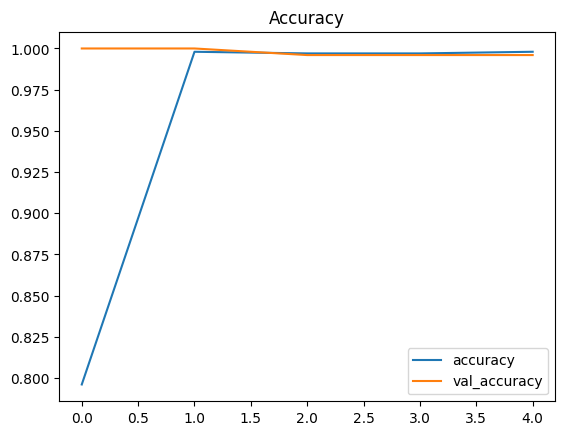

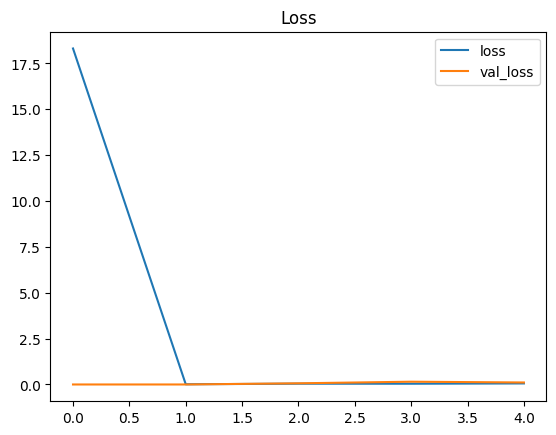

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

1/1 [==============================] - 0s 16ms/step


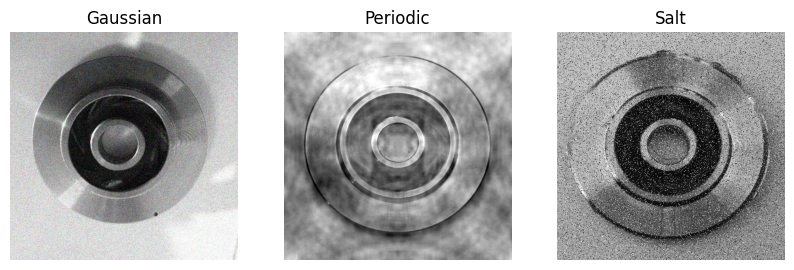

In [ ]:
import random

p = data[data['labels']==CLASSES[0]]['images'][data[data['labels']==CLASSES[0]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[0]].__len__()-1)]]
s = data[data['labels']==CLASSES[1]]['images'][data[data['labels']==CLASSES[1]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[1]].__len__()-1)]]
g = data[data['labels']==CLASSES[2]]['images'][data[data['labels']==CLASSES[2]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[2]].__len__()-1)]]

p_result = np.argmax(model.predict([load_test_image(p)]), axis=1)
s_result = np.argmax(model.predict([load_test_image(s)]), axis=1)
g_result = np.argmax(model.predict([load_test_image(g)]), axis=1)

plt_figure(
    [cv2.imread(p),cv2.imread(s),cv2.imread(g)],
    [f'{CLASSES[p_result[0]]}' , f'{CLASSES[s_result[0]]}', f'{CLASSES[g_result[0]]}'], 
    columns=3,
    w=10
    )

In [ ]:
model.save('./content/models/VGG16_Noise_Classification_Gen.h5')

## Inception ResNet V2

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

pretrained_model = InceptionResNetV2(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
from keras.layers import Dense
from keras import Model

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [ ]:
history = 0
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=val_gen,
        callbacks=my_callbacks,
        workers=1
        )

Epoch 1/25
32/32 [==============================] - 26s 521ms/step - loss: 4.5994 - accuracy: 0.8220 - val_loss: 0.2147 - val_accuracy: 0.9800 - lr: 0.0100
Epoch 2/25
32/32 [==============================] - 11s 332ms/step - loss: 0.1583 - accuracy: 0.9820 - val_loss: 0.1764 - val_accuracy: 0.9840 - lr: 0.0100
Epoch 3/25
32/32 [==============================] - 11s 332ms/step - loss: 0.0643 - accuracy: 0.9880 - val_loss: 2.9147e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 4/25
32/32 [==============================] - 11s 332ms/step - loss: 0.0088 - accuracy: 0.9960 - val_loss: 0.0314 - val_accuracy: 0.9920 - lr: 0.0100
Epoch 5/25
32/32 [==============================] - 11s 333ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 1.0563e-04 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 6/25
32/32 [==============================] - 11s 333ms/step - loss: 0.0062 - accuracy: 0.9970 - val_loss: 0.0092 - val_accuracy: 0.9960 - lr: 0.0100
Epoch 7/25
32/32 [==============================] - 11s 

In [ ]:
model.save('./content/models/InceptionResNetV2_Noise_Classification_Gen.h5')

In [ ]:
from sklearn.metrics import classification_report

predict = model.predict(val_gen)
print(classification_report(val_gen.labels, np.argmax(predict, axis=1)))

8/8 [==============================] - 5s 266ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       102
           2       1.00      1.00      1.00        70

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(val_gen)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 262ms/step - loss: 3.1518e-05 - accuracy: 1.0000
Test Accuracy: 100.0


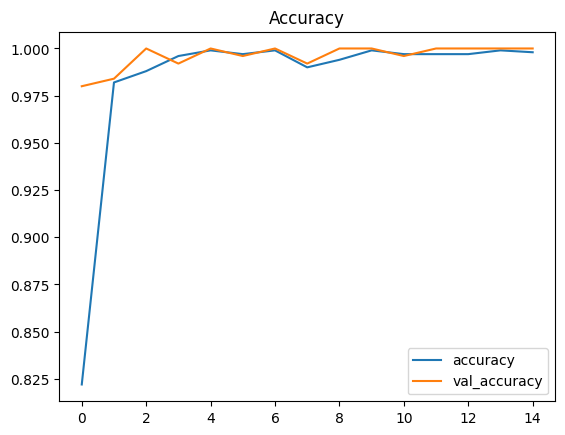

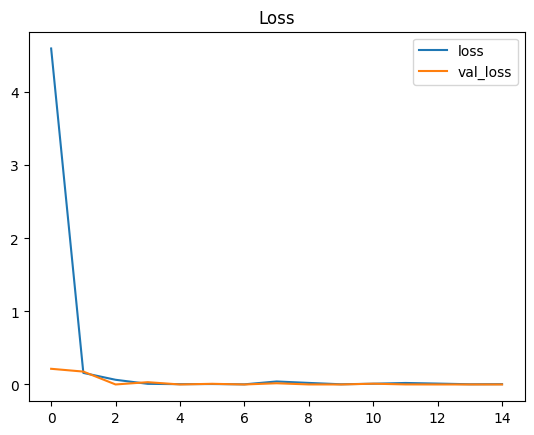

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

1/1 [==============================] - 4s 4s/step
Periodic


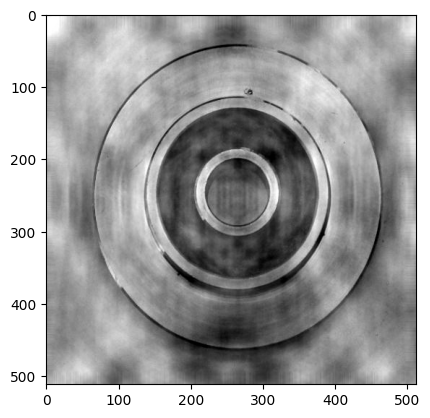

In [ ]:
import random

p = data[data['labels']==CLASSES[0]]['images'][data[data['labels']==CLASSES[0]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[0]].__len__()-1)]]
s = data[data['labels']==CLASSES[1]]['images'][data[data['labels']==CLASSES[1]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[1]].__len__()-1)]]
g = data[data['labels']==CLASSES[2]]['images'][data[data['labels']==CLASSES[2]]['images'].index[random.randrange(0,data[data['labels']==CLASSES[2]].__len__()-1)]]

p_result = np.argmax(model.predict([load_test_image(p)]), axis=1)
s_result = np.argmax(model.predict([load_test_image(s)]), axis=1)
g_result = np.argmax(model.predict([load_test_image(g)]), axis=1)

plt_figure(
    [cv2.imread(p),cv2.imread(s),cv2.imread(g)],
    [f'{CLASSES[p_result[0]]}' , f'{CLASSES[s_result[0]]}', f'{CLASSES[g_result[0]]}'], 
    columns=3,
    w=10
    )